In [300]:
# 작업 환경 설정
import matplotlib.dates as md
import pandas as pd
import numpy as np
import math
import datetime
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from matplotlib import rc

plt.style.use('seaborn')
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# Regression Project

## 주제 :  제주도의 전력 예측


## 데이터 
1. 기상/전력 데이터 https://dacon.io/competitions/official/235606/overview/ (데이콘)

2. 관광객 데이터 http://www.visitjeju.or.kr/web/bbs/bbsList.do?bbsId=TOURSTAT (제주도 관광협회)

3. 제주도 인구 데이터 https://www.jeju.go.kr/open/stats/news/trend.htm?act=view&seq=1162310&page=9 (제주도청)

4. 불쾌지수 데이터 (계산식 활용, 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3)

수집 기간 : 2018.02.01 ~ 2020.05.18

## 변수 :

1. 독립변수 
    - 온도 (temp, celcius)
    - 체감온도 (body_temp, celcius)
    - 풍속 (ws, m/s)
    - 습도 (humid, %)
    - 불쾌지수 (angry, d.index) 
    - 관광객 (tour, 명)
    - 가격(smp, 원/kWh)
    - 인구수(population)
   

2. 종속변수 
    - 전력공급량 (supply, 만kW)

### 기존 선행 연구(제주 전력 예측)

김기수,송경빈 / 송경빈한국조명·전기설비학회한국조명·전기설비학회 학술대회논문집 (2008.10) 225 - 228 

김기수, 류구현, 송경빈 /온도특성에 대한 데이터 정제를 이용한 제주도의 단기 전력수요예측 대한전기학회전기학회논문지 (2009.09) 1,695 - 1,699

구본희, 윤경하, 차준민 /기온특성을 고려한 제주지역 전력 수요 예측. 대한전기학회 학술대회 논문집 (2011.10) 250-253 

구본희, 차준민 / 기온변화특성을 이용한 제주계통 하절기 전력수요예측 대한전기학회대한전기학회 학술대회 논문집 (2012.05) 305 - 307

정희원, 구본희, 차준민/ 제주계통의 기온변화 민감도를 반영한 주말 전력수요예측 대한전기학회전기학회논문지 (2016.05) 718 - 723 (6 pages)

김혜민, 임병환, 유승훈/ 제주지역의 전력수요함수 추정 한국에너지학회한국에너지학회 학술발표회 (2017.04) 98-99 (역시 온도 고려)

배원식, 박정도, 송경빈 외 2명/ 제주도 단기 전력수요예측 개선을 위한 수요예측 오차분석 대한전기학회대한전기학회 학술대회 논문집 (2017.11)

-계절 월별로 전력수요를 나눠서 파악

김혜민, 김인겸, 이대근 외 2/ 기온변수를 이용한 제주지역의 전력수요함수 추정 명한국혁신학회한국혁신학회지13(2) 2018.05 105 - 120 (16 pages)

조세원, 박래준, 김경환 외 4명/ 제주도의 특수일 전력수요에 대한 기온 민감도 분석대한전기학회전기학회논문지67(8) 2018.08 1,019 - 1,023

조세원, 박래준, 송경빈/ 기상에 대한 동네예보를 활용한 제주도의 특수일 전력수요예측 알고리즘 한국조명·전기설비학회조명·전기설비학회논문지)(2019.06)

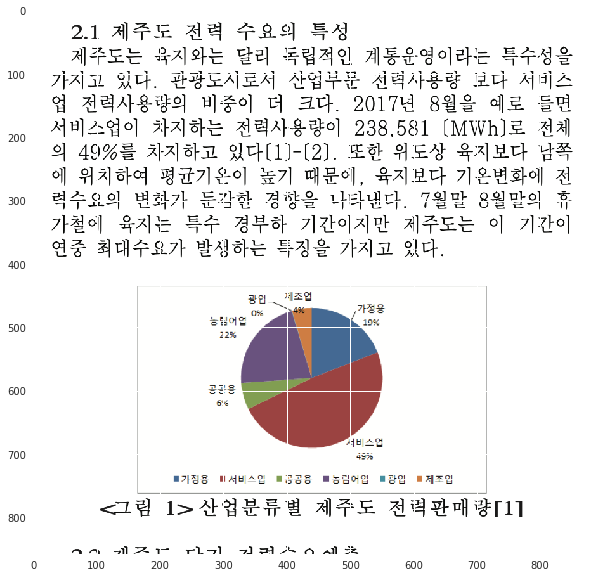

In [301]:
#제주도 산업 현황
plt.figure(figsize =(10, 10))
img1 = mpimg.imread('circle.png')
plt.imshow(img1)

기상변수를 이용한 도서지역 전력수요 예측모형의 적합성에 관한 연구  김영은 , 조용성, 김경남 신재생에너지 13(2), 2017.6, 84-93(10 pages) 

대도시 혹은 국가 전체를 대상 으로 적용되어 온 전력수요 예측 모형이 도서지역에도 동 일하게 적용될 수 있는지에 대한 고찰이 필요하다 

## 문제 정의 : 


# 기상 데이터 외 사회적 변수를 이용한 전력량 예측

## 전처리

#### 1) 날씨 데이터 불러오기
- ASOS 관측소의 데이터만 사용
- 전국적으로 ASOS가 관측한 기온이 공식으로 인정받고, AWS상의 기온은 참고용으로 사용
    - 참고자료: https://www.yna.co.kr/view/AKR20180723154300004

- area: 184(제주), 185(고산), 188(성산), 189(서귀포)

In [302]:
weather_df = pd.read_csv("weather_v2.csv")
weather_df = weather_df[weather_df["station"] == "ASOS"]

/Users/codefreak/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [303]:
##### datetime 컬럼을 date와 time으로 나누기

In [304]:
def split_date(data, col):
    date = data[col].str.split(' ').str[0]
    time = data[col].str.split(' ').str[1]
    return date, time
weather_df["date"], weather_df["time"] = split_date(weather_df, "datetime")

#### 2) 날씨 데이터의 36개의 독립변수 중 사용할 독립변수만 추출
- 온도, 풍속, 습도(상대) 사용

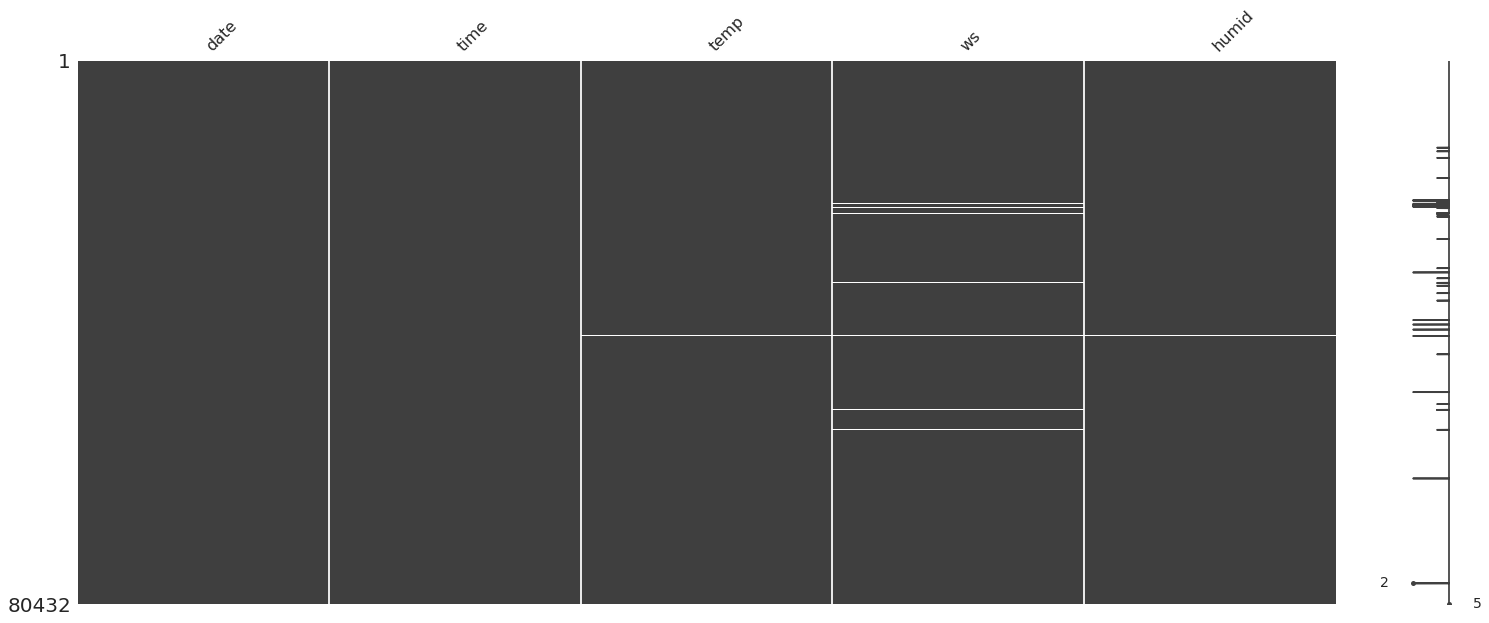

In [305]:
weather_useful = weather_df[["date", "time", "temp", "ws", "humid"]]
msno.matrix(weather_useful)
plt.show()

##### 결측값을 채운후 결측값 확인
- 제주도 지하수정보 관리시스템에서 강수 정보 확인 결과 결측데이터를 0으로 처리하기로 함

In [306]:
#온도 데이터 등 나머지 결측값들은 선형으로 채우기로 함
weather_full = weather_useful.interpolate(method='values') 
weather_full.isnull().sum()

date     0
time     0
temp     0
ws       0
humid    0
dtype: int64

In [307]:
# date의 자료형을 datetime으로 변환
weather_full['date'] = pd.to_datetime(weather_full['date'])
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80432 entries, 0 to 80431
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    80432 non-null  datetime64[ns]
 1   time    80432 non-null  object        
 2   temp    80432 non-null  float64       
 3   ws      80432 non-null  float64       
 4   humid   80432 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 3.7+ MB


In [308]:
# 일일 최고 최저기온 추가
temp_max = weather_full.groupby("date").max()["temp"].values
temp_min = weather_full.groupby("date").min()["temp"].values

#### 3) 체감온도 및 불쾌지수 추가
- 불쾌지수
    - 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3
    
- 체감온도
    - 기상자료개방포털 자료 활용 (각 관측소 184(제주), 185(고산), 188(성산), 189(서귀포)에서 측정된 일간 체감온도)
        
- 자료 출처 : 체감온도 - 기상청, 불쾌지수 - 위키백과

In [309]:
# 불쾌지수 연산 함수
def discomfort_index(temp, rh):
    discomfort = round(0.81 * temp + 0.01 * rh * (0.99 * temp - 14.3) + 46.3, 1)
    return discomfort

In [310]:
# 불쾌지수 추가
weather_full["angry"] = discomfort_index(weather_full["temp"], weather_full["humid"])

In [311]:
# 시간별, 관측소별로 나눠진 데이터들을 일일 평균으로 하나의 데이터로 합침
weather_full = weather_full.groupby("date").mean().reset_index()

In [312]:
# 체감온도 추가
body_temp = pd.read_csv("body_temp.csv")
body_temp = body_temp.drop("Unnamed: 0", axis = 1)

In [313]:
# 4개의 관측소의 평균 일별 체감온도 컬럼 추가
weather_full["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)
weather_full["body_temp"] = body_temp.groupby("date").mean().reset_index()["body_temp"].round(1)
weather_full["max_temp"] = temp_max
weather_full["min_temp"] = temp_min

In [314]:
weather_full.tail()

,date,temp,ws,humid,angry,body_temp,max_temp,min_temp
833,2020-05-14,18.710417,2.708333,56.291667,63.718750,18.6,24.2,10.4
834,2020-05-15,19.930208,3.497917,91.500000,67.272917,19.8,26.4,17.8
835,2020-05-16,17.560417,1.961458,96.583333,63.468750,17.4,21.3,13.4
836,2020-05-17,17.070833,2.247917,91.635417,62.404167,17.0,21.0,13.2
837,2020-05-18,19.205208,3.052083,92.135417,66.152083,19.1,28.4,14.4


#### 4) 상대습도(humid) 변환
- humid : % -> /100

In [315]:
weather_full["humid"] = weather_full["humid"] / 100
weather_full.tail()

,date,temp,ws,humid,angry,body_temp,max_temp,min_temp
833,2020-05-14,18.710417,2.708333,0.562917,63.718750,18.6,24.2,10.4
834,2020-05-15,19.930208,3.497917,0.915000,67.272917,19.8,26.4,17.8
835,2020-05-16,17.560417,1.961458,0.965833,63.468750,17.4,21.3,13.4
836,2020-05-17,17.070833,2.247917,0.916354,62.404167,17.0,21.0,13.2
837,2020-05-18,19.205208,3.052083,0.921354,66.152083,19.1,28.4,14.4


#### 5) 사회적 변수 추가(관광객, 인구 수)
- datetime의 데이터 타입을 datetime형태로 형변환
- tour에서 ' , ' 를 제외하고 int형태로 형변환

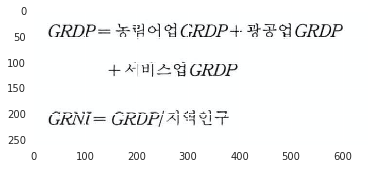

In [316]:
#남봉우, 송경빈, 김규호, 차준민 (2008). 다중회귀분석법을 이용한 지역전력수요예측 알고리즘. 조명전기설비학회 논문지, 22(2), 63-70 
# 지역전력수요예측 알고리즘을 개선하는 방향으로 로그 함수를 이용한 다중회귀분석을 제안한다.
img1 = mpimg.imread('local.png')
plt.imshow(img1)

In [317]:
# 관광객 데이터 추가
tour_df = pd.read_csv("tour_stat.csv")
tour_df["date"]= pd.to_datetime(tour_df["date"])
tour_df["tour"] =  tour_df["tour"].astype(int)
tour_df.tail()

,date,tour
833,2020-05-14,23327
834,2020-05-15,22135
835,2020-05-16,23009
836,2020-05-17,24394
837,2020-05-18,24001


In [318]:
# 인구 데이터 추가
kpi = pd.read_csv("kpi_pop.csv")[["month", "kpi", "population"]]

In [319]:
date = pd.date_range("2018-02-01", "2020-05-18", freq = "D")
date2 = date
date = pd.DataFrame(date)
date.rename(columns={0: 'date'}, inplace=True)
kpi["month"] = date2[date2.day == 1]
kpi.rename(columns={"month": 'date'}, inplace=True)
kpi = pd.merge(date, kpi, left_on='date', right_on='date', how='left')


In [320]:
kpi = pd.DataFrame(kpi)
kpi = kpi.interpolate(method='values')
kpi["population"] = kpi["population"].round(0)
kpi.tail()

,date,kpi,population
833,2020-05-14,105.18,670798.0
834,2020-05-15,105.18,670798.0
835,2020-05-16,105.18,670798.0
836,2020-05-17,105.18,670798.0
837,2020-05-18,105.18,670798.0


#### 6) target 데이터 불러오기
- 일별 최대 smp, 최소 smp, 평균 smp, 전력 수요량

In [321]:
# target 데이터 불러오기
target = pd.read_csv("target_v2.csv")
# target의 날짜 데이터의 자료형을 str -> datetime으로 변환
target['date'] = pd.to_datetime(target['date'])

#### 7) 날짜를 기준으로 날씨, 관광객, 인구수, 타겟 데이터프레임 병합

In [322]:
target_v2 = target.merge(weather_full)
target_v2 = target_v2.merge(tour_df)

In [323]:
target_v3 = pd.concat([target_v2, kpi[["population"]]], axis = 1)
target_v3.tail()

,date,smp_max,smp_min,smp_mean,supply,temp,ws,humid,angry,body_temp,max_temp,min_temp,tour,population
833,2020-05-14,193.28,66.78,100.46,62.70,18.710417,2.708333,0.562917,63.718750,18.6,24.2,10.4,23327,670798.0
834,2020-05-15,198.23,61.81,102.38,64.91,19.930208,3.497917,0.915000,67.272917,19.8,26.4,17.8,22135,670798.0
835,2020-05-16,220.91,88.50,121.19,61.75,17.560417,1.961458,0.965833,63.468750,17.4,21.3,13.4,23009,670798.0
836,2020-05-17,207.75,65.78,116.82,61.55,17.070833,2.247917,0.916354,62.404167,17.0,21.0,13.2,24394,670798.0
837,2020-05-18,113.31,66.86,98.98,63.91,19.205208,3.052083,0.921354,66.152083,19.1,28.4,14.4,24001,670798.0


#### 8) 여름철, 겨울철, 환절기에 따른 카테고리 컬럼 생성

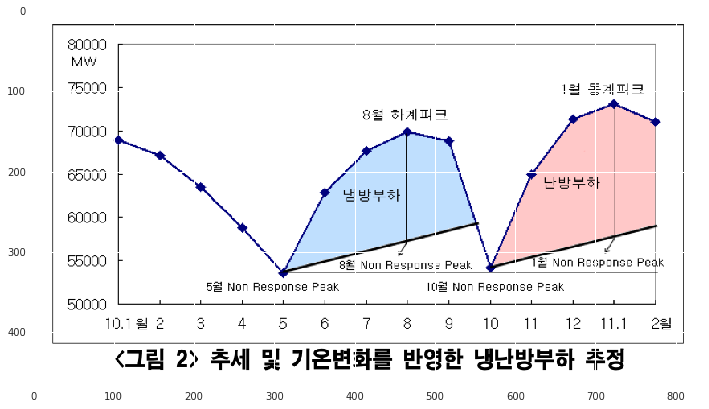

In [324]:
#최근 전력수요의 계절성 변화에 따른 냉․난방 부하 연구
#박종인(한국전력거래소),  김광인(한국전력거래소) 대한전기학회대한전기학회 학술대회 논문집2011 대한전기학회 하계학술대회 논문집2011.07
#삼계절법이 기존 이계절 전력 예측보다 훨씬 우수하다
#Taylor.J.W (2010) triple seasonal methods for short-term electricity demand forecasting.
#European Journal of Forecasting
plt.figure(figsize =(12, 12))

img1 = mpimg.imread('season.png')
plt.imshow(img1)


In [325]:
summer = np.logical_and((pd.DatetimeIndex(target_v2["date"]).month >= 6),\
                        (pd.DatetimeIndex(target_v2["date"]).month < 10))

# 난방기 기간 : 12월 ~ 3월
winter = np.logical_or((pd.DatetimeIndex(target_v2["date"]).month == 12),\
                        (pd.DatetimeIndex(target_v2["date"]).month <= 3))

# 환절기 : 4, 5 , 10, 11월
change_season = np.invert(np.logical_or(summer, winter))

target_v3["period"] = np.nan
period_winter = target_v3[winter]["period"].fillna("winter").reset_index(False)
period_summer = target_v3[summer]["period"].fillna("summer").reset_index(False)
period_cs = target_v3[change_season]["period"].fillna("cs").reset_index(False)
period = pd.concat([period_winter, period_summer, period_cs]).\
        sort_values(by=['index']).reset_index(drop=True)["period"]
target_v3["period"] = period

In [326]:
###GRNI 지수 추가
target_v3["GRNI"] = np.log(target_v3["tour"]/target_v3["population"])

In [327]:
# 컬럼 재정렬
target_v3 = target_v3[["date", "smp_max", "smp_min", "smp_mean",\
                       "temp", "max_temp", "min_temp", "ws", "humid",\
                       "angry", "body_temp", "tour", "population", "period", "supply","tour","GRNI"]]


#### 9) 데이터 overview

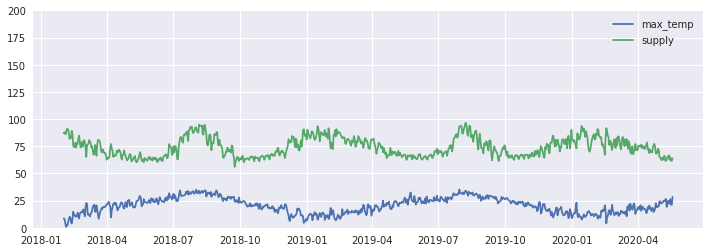

In [387]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'max_temp'], label='max_temp')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'supply'], label='supply')
plt.ylim(0,200)
plt.legend()
plt.show()

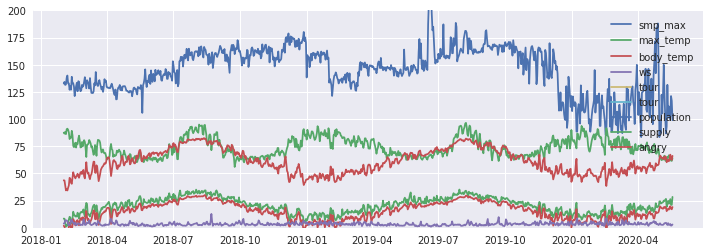

In [385]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'smp_mean'], label='smp_max')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'max_temp'], label='max_temp')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'body_temp'], label='body_temp')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'ws'], label='ws')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'tour'], label='tour')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'population'], label='population',)
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'supply'], label='supply')
plt.plot(target.loc[:, 'date'], target_v3.loc[:, 'angry'], label='angry')
plt.ylim(0,200)
plt.legend()
plt.show()

## 회귀분석

#### 1) OLS

In [395]:
target_v3.columns

Index(['date', 'smp_max', 'smp_min', 'smp_mean', 'temp', 'max_temp',
       'min_temp', 'ws', 'humid', 'angry', 'body_temp', 'tour', 'population',
       'period', 'supply', 'tour', 'GRNI'],
      dtype='object')

### 포뮬라 제조

## 신이레, 윤상후 (2016). 전력수요예측을 위한 기상정보 활용성평가. 한국데이터정보과학회지 
기상변수는 기상관측소에서 수집되는 기온 풍속 습도 운량 기압 기온 풍속 상대 습도 체감온도 불쾌지수가 고려 되었다.
## 송경빈 외 3명 (2017) 다중회귀분석법을 이용한 전력량 예측알고리즘 한국 전기설비학회
기상변수로서 최고온도가 불쾌지수 체감온도 등이 계절과 무관하게 사용되었다.


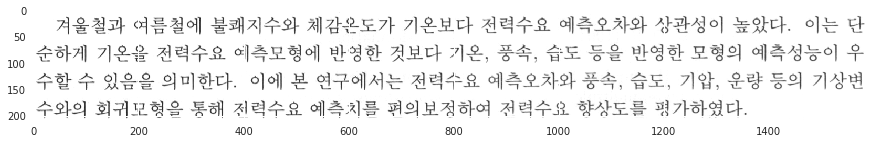

In [420]:
plt.figure(figsize =(15, 15))
img1 = mpimg.imread('temp.png')
plt.imshow(img1)

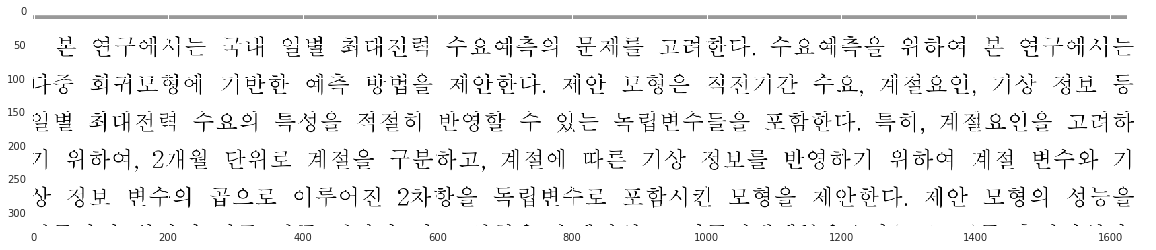

In [414]:
#이근철, 한정희 (2017). 국내 일별 최대전력 수요예측에 관한 연구. 산업경제연구, 30(4), 1205-1218 
img1 = mpimg.imread('multiply.png')
img2 = mpimg.imread('multiply2.png')
plt.figure(figsize =(20, 20))
plt.imshow(img1)

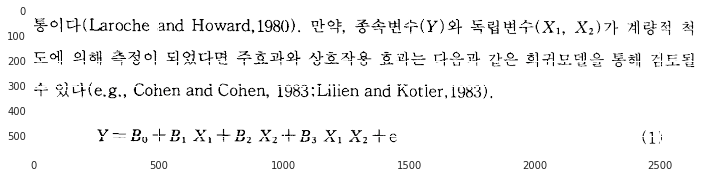

In [410]:
#상호작용효과를 포함한 다중회귀분석에서 주효과의 검증에 대한 연구
#이유재한국경영학회경영학연구23(4)1994.11
plt.imshow(img2)

In [415]:
formula = ("(supply)  ~ scale(max_temp)*C(period)+ I(scale(angry)*scale(max_temp)) +scale(GRNI)*C(period)+\
scale(smp_max)")

In [416]:
model = sm.OLS.from_formula(formula, data=target_v3)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     371.8
Date:                Thu, 02 Jul 2020   Prob (F-statistic):          5.79e-298
Time:                        15:10:39   Log-Likelihood:                -2295.5
No. Observations:                 838   AIC:                             4613.
Df Residuals:                     827   BIC:                             4665.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [357]:
result.pvalues

Intercept                              0.000000e+00
C(period)[T.summer]                    2.053726e-28
C(period)[T.winter]                    8.052268e-30
scale(max_temp)                        8.023990e-26
scale(max_temp):C(period)[T.summer]    6.120489e-33
scale(max_temp):C(period)[T.winter]    1.065834e-06
I(scale(angry) * scale(max_temp))      4.356202e-26
scale(GRNI)                            2.268347e-02
scale(GRNI):C(period)[T.summer]        2.535435e-02
scale(GRNI):C(period)[T.winter]        3.549067e-03
scale(smp_max)                         2.892111e-04
dtype: float64

#### 2)  모델 검증
교차 검증

장점 : 

1. 모든 데이터 셋을 평가에 활용할 수 있다.

  - 평가에 사용되는 데이터 편중을 막을 수 있다. 

  - 평가 결과에 따라 좀 더 일반화된 모델을 만들 수 있다. 

2. 모든 데이터 셋을 훈련에 활용할 수 있다.

  - 정확도를 향상시킬 수 있다.

  - 데이터 부족으로 인한 underfitting을 방지할 수 있다.


단점 : Iteration 횟수가 많기 때문에 모델 훈련/평가 시간이 오래 걸린다.


In [379]:
target = target_v3
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(target, test_size=0.3, random_state=0)
df_train.shape, df_test.shape

((586, 17), (252, 17))

In [380]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(target)):
    df_train = target.iloc[idx_train]
    df_test = target.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula, data=target)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.supply - pred) ** 2).sum()
    tss = ((df_test.supply - df_test.supply.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.81802530, 검증 R2 = 0.80985228
학습 R2 = 0.81802530, 검증 R2 = 0.77261241
학습 R2 = 0.81802530, 검증 R2 = 0.83188587
학습 R2 = 0.81802530, 검증 R2 = 0.82601095
학습 R2 = 0.81802530, 검증 R2 = 0.83675745


### 예측과 실제 데이터 비교

In [361]:
model_real = sm.OLS.from_formula(formula, data=target)
result_real = model_real.fit()
print(result_real.summary())

                            OLS Regression Results                            
Dep. Variable:                 supply   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     371.8
Date:                Thu, 02 Jul 2020   Prob (F-statistic):          5.79e-298
Time:                        14:50:27   Log-Likelihood:                -2295.5
No. Observations:                 838   AIC:                             4613.
Df Residuals:                     827   BIC:                             4665.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

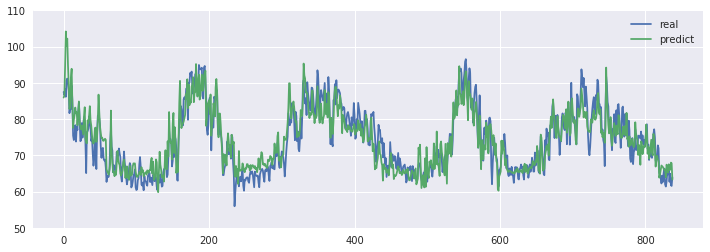

In [371]:
test2 = target
ypred = result_real.predict(test2)
plt.figure(facecolor="1")
plt.plot(test2["supply"],label='real')
plt.plot(ypred,label='predict')
plt.ylim(50,110)
plt.legend()
plt.show()

프로젝트를 마치며

단순 다중회기 방법으로 현제 사용되는 인공신경망과 시계열 방법의 전력수요 예측에 성능에 미치지 못한점이 매우 아쉽다.
데이터를 구할때 시간 단위 데이터를 구하거나, 좀 더 풍부한 데이터가 있었으면 어땠을까 하는 생각이 든다.
특수일을 고려한 퍼지선형 방법과 예측일 전의 전력량을 이용한 방법, 측정 데이터의 측정자 오차 보정 같은 것들을 한다면 좀더 
성능이 좋아질것 같다.


## 참고문헌



김기수,송경빈 / 송경빈한국조명·전기설비학회한국조명·전기설비학회 학술대회논문집 (2008.10) 225 - 228 

김기수, 류구현, 송경빈 /온도특성에 대한 데이터 정제를 이용한 제주도의 단기 전력수요예측 대한전기학회전기학회논문지 (2009.09) 1,695 - 1,699

구본희, 윤경하, 차준민 /기온특성을 고려한 제주지역 전력 수요 예측. 대한전기학회 학술대회 논문집 (2011.10) 250-253 

구본희, 차준민 / 기온변화특성을 이용한 제주계통 하절기 전력수요예측 대한전기학회대한전기학회 학술대회 논문집 (2012.05) 305 - 307

정희원, 구본희, 차준민/ 제주계통의 기온변화 민감도를 반영한 주말 전력수요예측 대한전기학회전기학회논문지 (2016.05) 718 - 723 (6 pages)

김혜민, 임병환, 유승훈/ 제주지역의 전력수요함수 추정 한국에너지학회한국에너지학회 학술발표회 (2017.04) 98-99 (역시 온도 고려)

배원식, 박정도, 송경빈 외 2명/ 제주도 단기 전력수요예측 개선을 위한 수요예측 오차분석 대한전기학회대한전기학회 학술대회 논문집 (2017.11)

김혜민, 김인겸, 이대근 외 2/ 기온변수를 이용한 제주지역의 전력수요함수 추정 명한국혁신학회한국혁신학회지13(2) 2018.05 105 - 120 (16 pages)

조세원, 박래준, 김경환 외 4명/ 제주도의 특수일 전력수요에 대한 기온 민감도 분석대한전기학회전기학회논문지67(8) 2018.08 1,019 - 1,023

조세원, 박래준, 송경빈/ 기상에 대한 동네예보를 활용한 제주도의 특수일 전력수요예측 알고리즘 한국조명·전기설비학회조명·전기설비학회논문지)(2019.06)

기상변수를 이용한 도서지역 전력수요 예측모형의 적합성에 관한 연구  김영은 , 조용성, 김경남 신재생에너지 13(2), 2017.6, 84-93(10 pages) 

남봉우, 송경빈, 김규호, 차준민 (2008). 다중회귀분석법을 이용한 지역전력수요예측 알고리즘. 조명전기설비학회 논문지, 22(2), 63-70 

박종인(한국전력거래소),  김광인(한국전력거래소) 대한전기학회대한전기학회 학술대회 논문집2011 대한전기학회 하계학술대회 논문집2011.07

Taylor.J.W (2010) triple seasonal methods for short-term electricity demand forecasting.

신이레, 윤상후 (2016). 전력수요예측을 위한 기상정보 활용성평가. 한국데이터정보과학회지 

송경빈 외 3명 (2017) 다중회귀분석법을 이용한 전력량 예측알고리즘 한국 전기설비학회

이근철, 한정희 (2017). 국내 일별 최대전력 수요예측에 관한 연구. 산업경제연구, 30(4), 1205-1218 

상호작용효과를 포함한 다중회귀분석에서 주효과의 검증에 대한 연구 이유재 한국경영학회경영학연구23(4)1994.11


In [ ]:
#교차검증이 유용한 이유?